**INSTALLS**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# %cd /content/drive/MyDrive/ML4641_Team1/Clustering_SL
%cd /content/drive/MyDrive/GT/ML4641_Team1/Clustering_SL

/content/drive/.shortcut-targets-by-id/1tRjOqnViZ2x2IwMRezEXautrm4Fq213j/ML4641_Team1/Clustering_SL


In [6]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image, display_svg, SVG

# avoid "Arial font not found" warnings
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

**HELPER FUNCTIONS**

Function 1: Cleans Data based off of Z-score [working]

In [7]:
# This functions removes all rows from the DataFrame df whose feature value has z-score above 3 or below -3
def remove_outliers_Z_score(df: pd.DataFrame, feature: str):
    z_scores = np.abs(stats.zscore(df[feature]))
    too_high_indices =  np.where(z_scores > 3)[0]
    too_low_indices = np.where(z_scores < -3)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 2: Cleans Data based off of IQR [not working]

In [8]:
# This function removes all rows from the DataFrame df whose feature value is above Q3 + 1.5 * IQR or below Q1 - 1.5 * IQR
# UPDATE: This is giving me issues. Probably better to use Z-score to remove outliers for this dataset
def remove_outliers_IQR(df: pd.DataFrame, feature: str):
    Q1 = np.percentile(df[feature], 25, method = 'midpoint')
    Q3 = np.percentile(df[feature], 75, method = 'midpoint')
    IQR = Q3 - Q1
    too_high_indices = np.where(df[feature] >= Q3 + 1.5 * IQR)[0]
    too_low_indices = np.where(df[feature] <= Q1 - 1.5 * IQR)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 3: Splits pandas DataFrame into training set and testing set
(Note: Clustering is unsupervised, so it does not make sense to have a train/test split.)

In [9]:
# This function splits a pandas DataFrame into a training set and a test set, specificed by the train_ratio.
def split_dataset(df: pd.DataFrame, train_ratio: float):
  train_indices = np.random.rand(len(df)) < train_ratio
  return df[train_indices], df[~train_indices]

Function 4: Performs one-hot encoding, converting categorical (especially binary) to numerical data.

In [10]:
# This function converts a categorical feature (original_feature) to numerical data (encoded_feature), via one-hot encoding.
# Typically converts yes/no to 1/0.
def encode_cat_to_num(df: pd.DataFrame, original_feature: str, encoded_feature: str):
    df[original_feature] = df[original_feature].astype('category')
    df[encoded_feature] = df[original_feature].cat.codes

**LOAD DATA**

In [13]:
# Housing prices: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data
#housing_prices_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Clustering_SL/kaggle_housing_prices.csv")

# Realtor data: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset. Note that this dataset is from Puerto Rico and the US Northeast.
#realtor_data_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Clustering_SL/kaggle_realtor_data.csv")

# Housing prices: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data
housing_prices_df = pd.read_csv("/content/drive/MyDrive/GT/ML4641_Team1/Clustering_SL/kaggle_housing_prices.csv")

# Realtor data: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset. Note that this dataset is from Puerto Rico and the US Northeast.
realtor_data_df = pd.read_csv("/content/drive/MyDrive/GT/ML4641_Team1/Clustering_SL/kaggle_realtor_data.csv")

**VISUALIZE DATA**

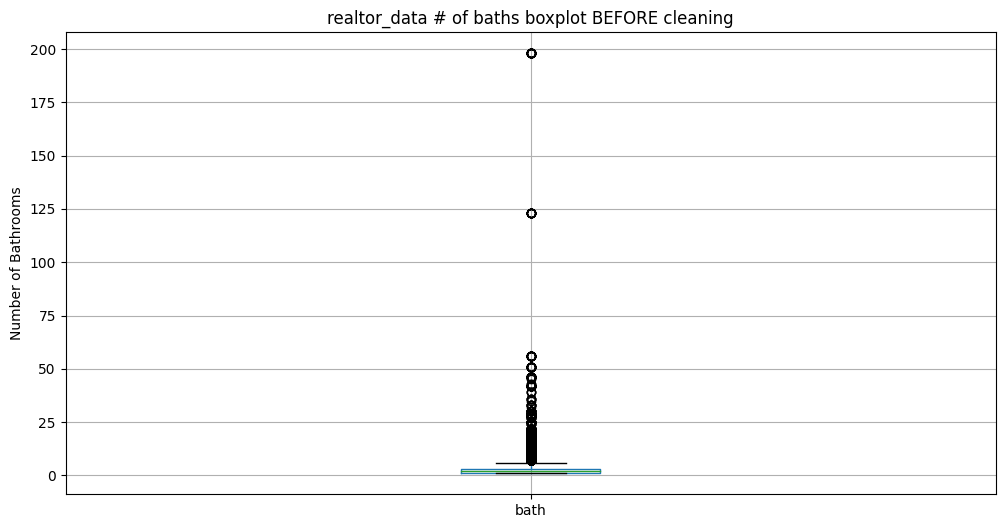

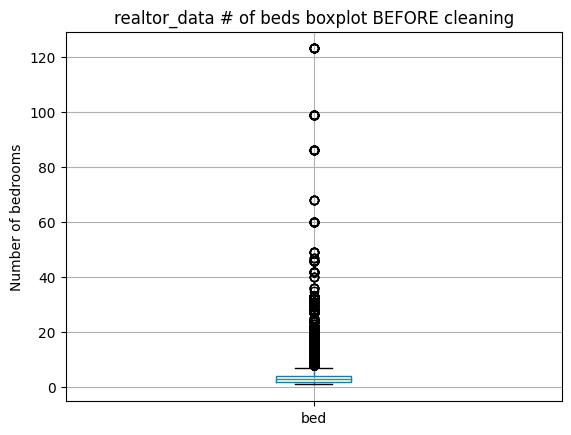

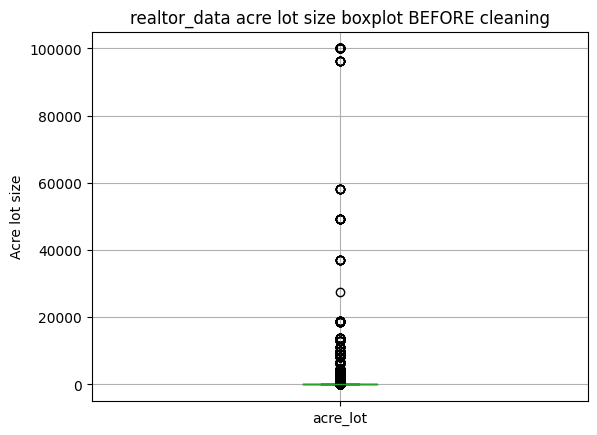

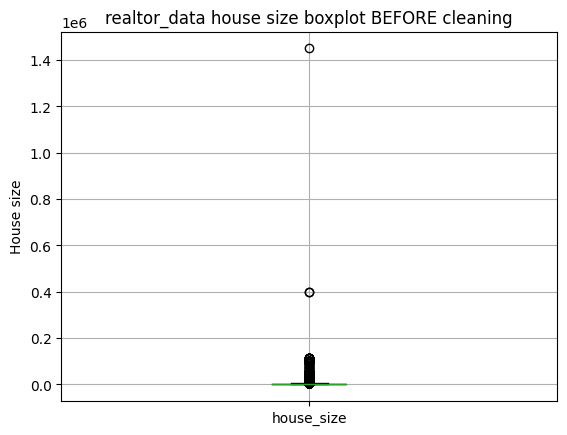

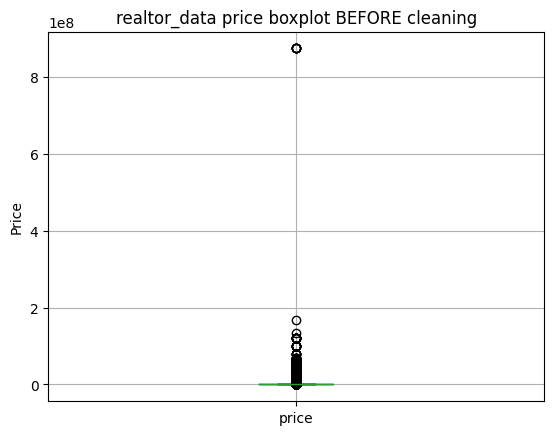

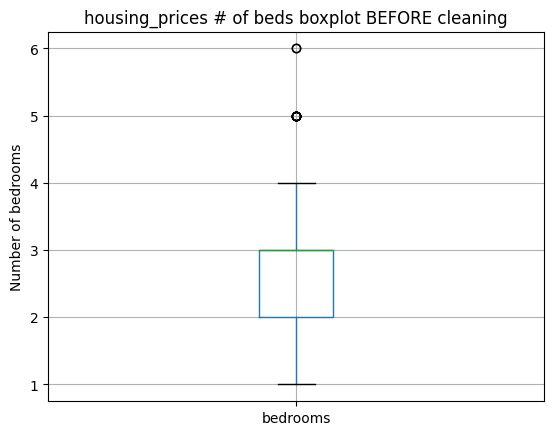

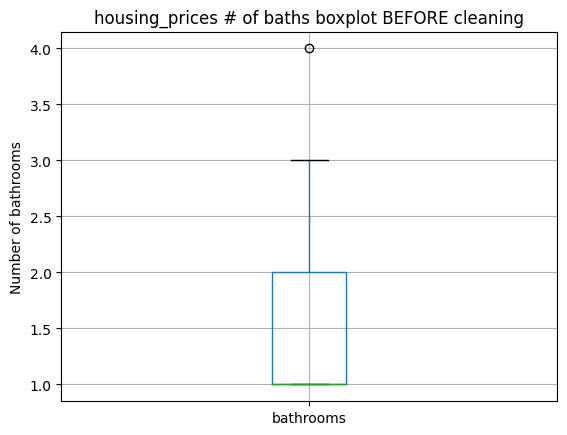

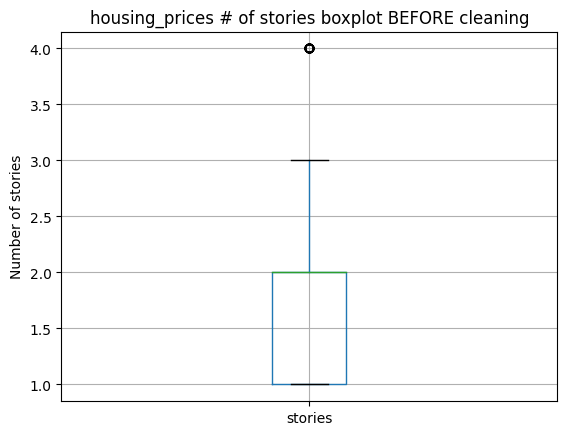

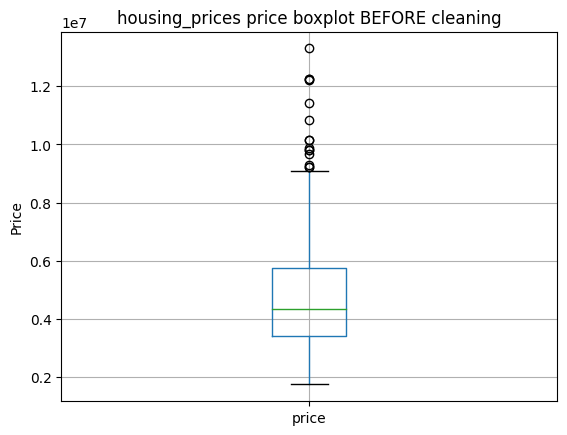

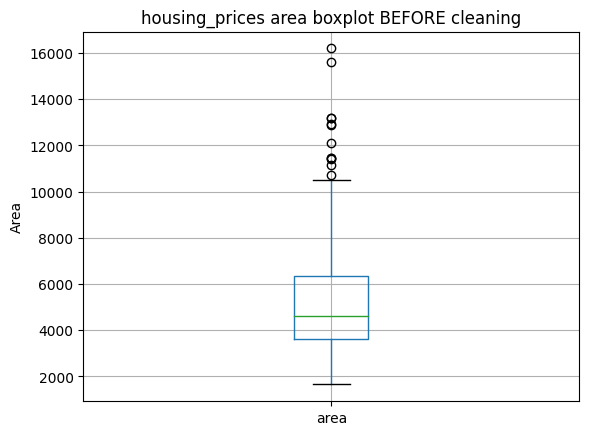

<Figure size 640x480 with 0 Axes>

'\nI think housing_prices is the better dataset, and the one we should use. The range of values for number of bedrooms, bathrooms, stories, etc. are clearly within reasonable range,\nwhereas in realtor_data some values are quite exorbitant (e.g. 100 or 200 bathrooms) and do not really make sense.\n'

In [14]:
# Visualize the data- this will be helpful in deciding which dataset to use and (possibly) removing outliers.

plt.figure(figsize=(12, 6))

#########################
# realtor_data
#########################

# boxplot of number of bathrooms
realtor_data_df.boxplot(column='bath')
plt.title('realtor_data # of baths boxplot BEFORE cleaning')
plt.ylabel('Number of Bathrooms')
plt.show()

# Would a house really have 100 or 200 bathrooms? Could it be a mansion or mega commercial building?

# boxplot of number of bedrooms
realtor_data_df.boxplot(column='bed')
plt.title('realtor_data # of beds boxplot BEFORE cleaning')
plt.ylabel('Number of bedrooms')
plt.show()

# Again, some houses have like 100 or 120 bathrooms. Need to determine how to handle outliers.

# boxplot of acre lot size
realtor_data_df.boxplot(column='acre_lot')
plt.title('realtor_data acre lot size boxplot BEFORE cleaning')
plt.ylabel('Acre lot size')
plt.show()

# boxplot of house size
realtor_data_df.boxplot(column='house_size')
plt.title('realtor_data house size boxplot BEFORE cleaning')
plt.ylabel('House size')
plt.show()

# boxplot of price
realtor_data_df.boxplot(column='price')
plt.title('realtor_data price boxplot BEFORE cleaning')
plt.ylabel('Price')
plt.show()

#########################
# housing_prices
#########################

# boxplot of number of bedrooms
housing_prices_df.boxplot(column='bedrooms')
plt.title('housing_prices # of beds boxplot BEFORE cleaning')
plt.ylabel('Number of bedrooms')
plt.show()

# boxplot of number of bathrooms
housing_prices_df.boxplot(column='bathrooms')
plt.title('housing_prices # of baths boxplot BEFORE cleaning')
plt.ylabel('Number of bathrooms')
plt.show()

# boxplot of number of stories
housing_prices_df.boxplot(column='stories')
plt.title('housing_prices # of stories boxplot BEFORE cleaning')
plt.ylabel('Number of stories')
plt.show()

# boxplot of price
housing_prices_df.boxplot(column='price')
plt.title('housing_prices price boxplot BEFORE cleaning')
plt.ylabel('Price')
plt.show()

# boxplot of area
housing_prices_df.boxplot(column='area')
plt.title('housing_prices area boxplot BEFORE cleaning')
plt.ylabel('Area')
plt.show()
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

"""
I think housing_prices is the better dataset, and the one we should use. The range of values for number of bedrooms, bathrooms, stories, etc. are clearly within reasonable range,
whereas in realtor_data some values are quite exorbitant (e.g. 100 or 200 bathrooms) and do not really make sense.
"""


**CLEAN AND TRAIN**

In [16]:
#################################################
############# First clean the data. #############
#################################################

print("-----STARTING-----\n")

# We agreed that housing_prices numerical attributes are fine as they are (i.e. no outliers), but we need to convert categorical attributes to numerical.

encoder = OneHotEncoder()
encode_cat_to_num(housing_prices_df, 'mainroad', 'has_mainroad')
encode_cat_to_num(housing_prices_df, 'guestroom', 'has_guestroom')
encode_cat_to_num(housing_prices_df, 'basement', 'has_basement')
encode_cat_to_num(housing_prices_df, 'hotwaterheating', 'has_hot_water_heating')
encode_cat_to_num(housing_prices_df, 'airconditioning', 'has_AC')
encode_cat_to_num(housing_prices_df, 'prefarea', 'in_preferred_area')

mapping = {'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0}
housing_prices_df['is_furnished'] = housing_prices_df['furnishingstatus'].map(mapping)

# Fill all missing values with the mode of their respective column
housing_prices_df_encoded = housing_prices_df.fillna(housing_prices_df.mode().iloc[0])

# Save final cleaned dataframe as csv file.
# housing_prices_df_encoded.to_csv("/content/drive/MyDrive/ML4641_Team1/Clustering_SL/housing_prices_encoded.csv")
housing_prices_df_encoded.to_csv("/content/drive/MyDrive/GT/ML4641_Team1/Clustering_SL/housing_prices_encoded.csv")


print("-----FINISHED-----\n")

-----STARTING-----

-----FINISHED-----



In [19]:
#################################################
############ Now we train our model. ############
#################################################

print("-----STARTING-----\n")

# DBSCAN (reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

columns_of_interest = housing_prices_df_encoded[["price", "area", "bedrooms", "bathrooms", "stories", "parking", "has_mainroad", "has_guestroom", "has_basement", "has_hot_water_heating",
                                                "has_AC", "in_preferred_area", "is_furnished"]]
# Standardize the data (from columns_of_interest).
scaler = StandardScaler()
columns_of_interest_scaled = scaler.fit_transform(columns_of_interest)

# Perform DBScan.
dbscan_clusters= DBSCAN(eps = 0.3, min_samples = 10).fit_predict(columns_of_interest_scaled)

# Display DBScan results. Note that it is probably difficult with more than 3 features.
plt.figure(figsize=(8, 6))
# Scatter plot for each cluster
cluster_data = None
for cluster in set(dbscan_clusters):
    cluster_data = columns_of_interest_scaled[dbscan_clusters == cluster]
    plt.scatter(cluster_data['area'], cluster_data['price'], label=f'Cluster {cluster}')

"""
labels = dbscan_results.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_noise_points = list(labels).count(-1)

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % num_noise_points)
"""
# K-means

# GMM

print("\n-----FINISHED-----")

-----STARTING-----



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 800x600 with 0 Axes>

**DISPLAY RESULTS**

In [20]:
print("-----STARTING-----")

# Display results
dt_viz = dtreeviz.model(dt_model, tree_index=0,
                           X_train=train_set[features], y_train=train_set[target],
                           feature_names=features,
                           target_name=target)

v = dt_viz.view()
v.show()
v.save("/content/drive/MyDrive/ML4641_Team1/dt_viz.svg")

print("\n-----FINISHED-----")

-----STARTING-----


NameError: name 'dtreeviz' is not defined

**EVALUATE ACCURACY IN DETAIL**

In [ ]:
print("-----STARTING-----")
# from Arian's version of this notebook
# Evaluate accuracy
dt_model.compile(metrics=['accuracy'])
results = dt_model.evaluate(test_tf_set, return_dict=True, verbose=0)
predictions = dt_model.predict(test_tf_set)
ground_truths = test_set_with_kept_features[target].values

# Get predicted values of y, and evaluate them.
y_pred = np.argmax(predictions, axis = 1)
precision = precision_score(ground_truths, y_pred, average='weighted')
recall = recall_score(ground_truths, y_pred, average='weighted')
f1 = f1_score(ground_truths, y_pred, average='weighted')

print("Accuracy:", results['accuracy'])
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\n-----FINISHED-----")